In [1]:
import pySim_lib as pysim
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree


plt.rcParams.update({"text.usetex": True})

# Read in dm particles from Gadget4 binary file
def GadgetReader(filename):
    header = pysim.read_header_gadget4(fname=filename)
    print(header)
        
    gadget4 = pysim.read_dark_matter_gadget4(fname=filename, load_pos=True, load_vel=True)

    idx = np.argsort(gadget4['ids'])
    gadget4['ids'] = gadget4['ids'][idx]
    gadget4['pos'] = gadget4['pos'][idx].T
    gadget4['vel'] = gadget4['vel'][idx].T
    return gadget4
filename = "2lpt_0000"
particles_data = GadgetReader(f'/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/input/2lpt_input/{filename}.bin')

#export to .dat file
positions = particles_data['pos'].T  # Transpose to get the right shape
velocities = particles_data['vel'].T
data_to_save = np.hstack((positions, velocities))
print(data_to_save.shape)
np.savetxt(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/input/2lpt_input/{filename}.dat", data_to_save, fmt="%.6f", delimiter = "\t", comments="")

{'BoxSize': 268.0, 'DMFile': '/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/input/2lpt_input/2lpt_0000.bin', 'Redshift': 0.0, 'Time': 1.0, 'NpartTotal': np.uint64(2097152), 'NpartHere': np.uint64(2097152), 'ParticleMass': np.float64(81.15333981013046), 'Nfiles': 1, 'WhichSpectrum': 1, 'UseRadiation': 0}
Allocating memory for 2097152 particles 24.0Mb
Read data in file #0 for 2097152/2097152 particles...
(2097152, 6)


In [2]:
#read in voids from voidfinder
def voidfinder_reader(filename):
    voids = np.loadtxt(filename)
    radius = voids[:, 0]        
    coords = voids[:, 1:4]     
    velocities = voids[:, 4:7] 
    return radius, coords, velocities

void_data_incl_small = voidfinder_reader(f'/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/output/2lpt_output/void_{filename}.dat')
#print(void_data)

In [3]:
#delete small voids
a = 268
V_box = a**3
N_particles = len(data_to_save) 
print("N_particles = ", N_particles)
r_min = (V_box / N_particles)**(1/3) * 2.5
print("r_min = ", r_min)
radii_incl_small, coords_incl_small, velocities_incl_small = void_data_incl_small 

allowed = radii_incl_small > r_min  

radii = radii_incl_small[allowed]
coords = coords_incl_small[allowed]
velocities = velocities_incl_small[allowed]

void_data = np.column_stack((radii, coords, velocities))


N_particles =  2097152
r_min =  5.234375


/var/folders/ss/qz81s18561g4v9nxv6k7wq_w0000gn/T/ipykernel_52708/91182763.py:10: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(coords_incl_small[mask, 0], coords_incl_small[mask, 1], s=15, c='blue', label='Voids', edgecolors='blue', linewidths=1, marker='x')


Text(0.5, 1.0, '2LPT Spatial Distribution')

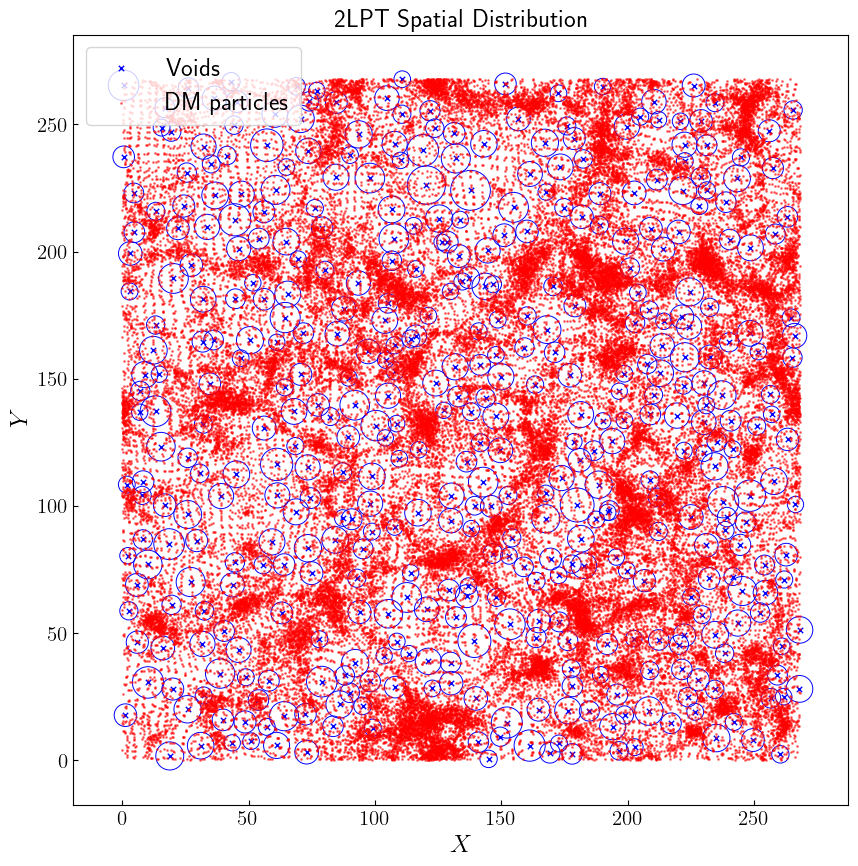

In [4]:
import matplotlib.patches as patches

z_min = 0
z_max = 10
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10), dpi=100)

#plot (x,y) of voids

mask = (coords_incl_small[:, 2] >= z_min) & (coords_incl_small[:, 2] <= z_max)
ax.scatter(coords_incl_small[mask, 0], coords_incl_small[mask, 1], s=15, c='blue', label='Voids', edgecolors='blue', linewidths=1, marker='x')
plt.legend(fontsize = 18)

for x, y, r in zip(coords_incl_small[mask, 0], coords_incl_small[mask, 1], radii_incl_small[mask]):
    circle = patches.Circle((x, y), r, color='blue', fill=False, linewidth=0.7)
    ax.add_patch(circle)

plt.legend(fontsize=18)


#plot (x,y) of dm particles

data_particles=np.loadtxt(f'/Users/CHermann/Desktop/MPE/Bachelor_thesis/Sparkling/input/2lpt_input/{filename}.dat')
positions = data_particles[:, 0:3]
velocities_particles = data_particles[:, 3:6]
mask = (positions[:,2] >= z_min) & (positions[:,2] <= z_max)
ax.scatter(positions[mask, 0], positions[mask, 1], s=1, alpha= 0.5, c='red', label='DM particles')
plt.legend(fontsize = 18)

ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)
plt.xlabel("$X$", fontsize=18)
plt.ylabel("$Y$", fontsize=18)
plt.title("2LPT Spatial Distribution", fontsize=18)



Text(0.5, 1.0, 'Continuous Void Size Function 2LPT')

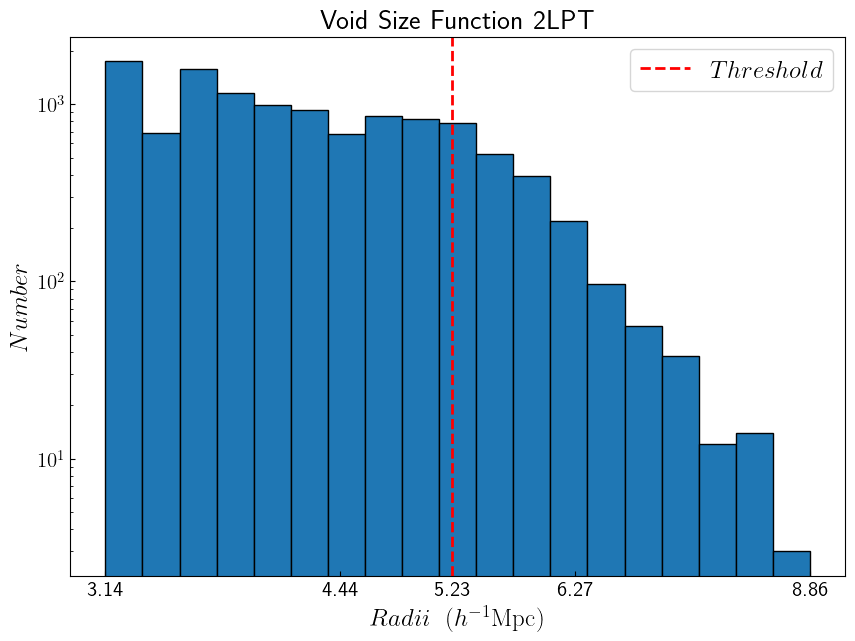

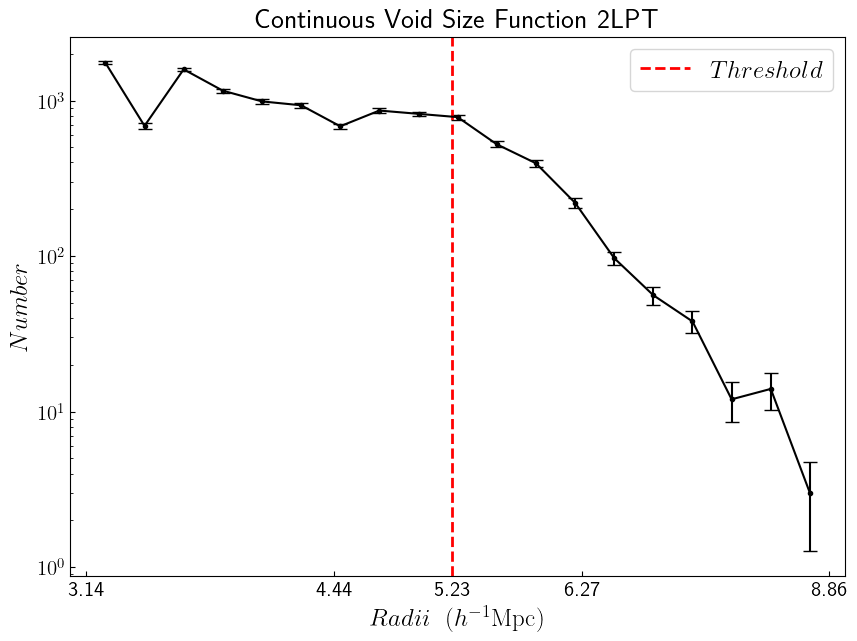

In [5]:
#void size function

#histogram void sizes
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)

bins = np.logspace(np.log10(min(radii_incl_small)), np.log10(max(radii_incl_small)), 20)
hist, bin_edges, _ = ax.hist(radii_incl_small, bins=bins, edgecolor='black')
ax.set_xscale('log')
ax.set_yscale('log')

ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)

ticks = np.logspace(np.log10(min(radii_incl_small)), np.log10(max(radii_incl_small)), 4)
ticks = np.append(ticks, r_min)  

ax.set_xticks(ticks)
ax.set_xticks([], minor=True)  
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}".rstrip('0').rstrip('.')))  

ax.axvline(x=r_min, color='red', linestyle='--', linewidth=2, label='$Threshold$')
plt.legend(fontsize = 18)

plt.xlabel('$Radii$ \  $ (h^{-1} \mathrm{Mpc})$', fontsize = 18)
plt.ylabel('$Number$', fontsize = 18)
plt.title('Void Size Function 2LPT', fontsize = 20)

#continuous void size function
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)
errors = np.sqrt(hist)

bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

ax.errorbar(bin_centers, hist, yerr=errors, fmt='o', color='black', linestyle='-', capsize=5, markersize=3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)

ticks = np.logspace(np.log10(min(radii_incl_small)), np.log10(max(radii_incl_small)), 4)
ticks = np.append(ticks, r_min)  
ax.set_xticks(ticks)
ax.set_xticks([], minor=True)  # Entferne Minor-Ticks, falls nötig
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}".rstrip('0').rstrip('.')))  

ax.axvline(x=r_min, color='red', linestyle='--', linewidth=2, label='$Threshold$')
plt.legend(fontsize = 18)

plt.xlabel('$Radii$  \ $(h^{-1}  \mathrm{Mpc})$', fontsize = 18)
plt.ylabel('$Number$', fontsize = 18)
plt.title('Continuous Void Size Function 2LPT', fontsize = 20)

Text(0.5, 1.0, '2LPT Velocity Distribution')

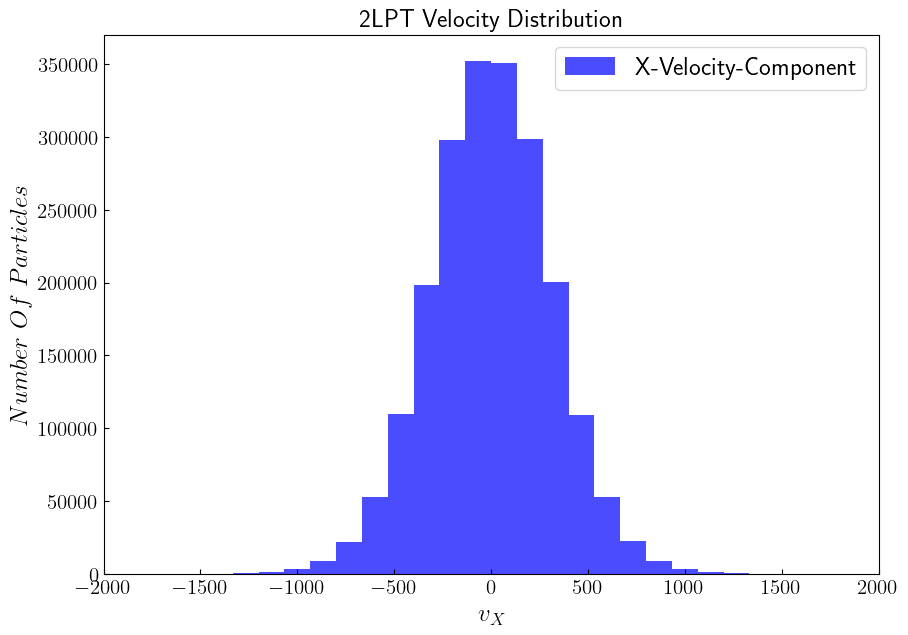

In [6]:
#plot histogram of particle velocities
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)
#we already saved velocities_particles
x_min, x_max = -2000, 2000
bins = np.linspace(x_min, x_max, 31)
result = ax.hist(velocities_particles[:, 1], bins=bins, color='blue', alpha=0.7, label='X-Velocity-Component')
plt.legend(fontsize = 18)
plt.xlim(x_min, x_max)

ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)
plt.xlabel("$v_X$", fontsize=18)
plt.ylabel("$Number \ Of \ Particles$", fontsize=18)
plt.title("2LPT Velocity Distribution", fontsize=18)



In [7]:
#integrated density profile
tree = cKDTree(positions, boxsize=a + 1e-6)
n_m = N_particles/V_box

#define 4 bins
R_max = np.max(void_data[:,0])
print("R_max=", R_max)
delta_profiles_groups = {1: [], 2: [], 3: [], 4: []}
radii_groups = {1: [], 2: [], 3: [], 4: []}

#sort voids
sorted_voids = np.sort(void_data[:, 0])
group_limits = np.percentile(sorted_voids, [25, 50, 75, 100])
print(group_limits)

#define 30 R bins
scaled_bins = np.linspace(0, 10, 31)  # 30 bins
scaled_bin_centers = (scaled_bins[:-1] + scaled_bins[1:]) / 2

density_profile = []

for i, void in enumerate(void_data):
    R_v_i = void[0]       
    center = void[1:4]

    #find the right bin for each void
    group = None
    if r_min <= R_v_i < group_limits[0]:  # < 25%
        group = 1
    elif group_limits[0] <= R_v_i < group_limits[1]:  # 25% - 50%
        group = 2
    elif group_limits[1] <= R_v_i < group_limits[2]:  # 50% - 75%
        group = 3
    else:  
        group = 4 #put everything above in 4

    #physical bins(R)
    bins = scaled_bin_centers * R_v_i
    density_profile = []

    for r in bins:
        indices = tree.query_ball_point(center, r)
        n_particles = len(indices)
        
        density = n_particles / ((4/3) * np.pi * r**3) 
        density_profile.append(density)
    density_profile = np.array(density_profile)

    #like delta = (n / n_m) - 1
    delta_profile = density_profile / n_m - 1
    delta_profiles_groups[group].append(delta_profile)
    radii_groups[group].append(R_v_i)
    
np.save(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/2LPT_results/Numpy_files/{filename}_integrated_delta_profiles_population_spaced_groups.npy", (delta_profiles_groups, radii_groups))

R_max= 8.85983
[5.39568   5.640455  6.0288675 8.85983  ]


[5.2, 5.4, 5.6, 6.0, 8.9]


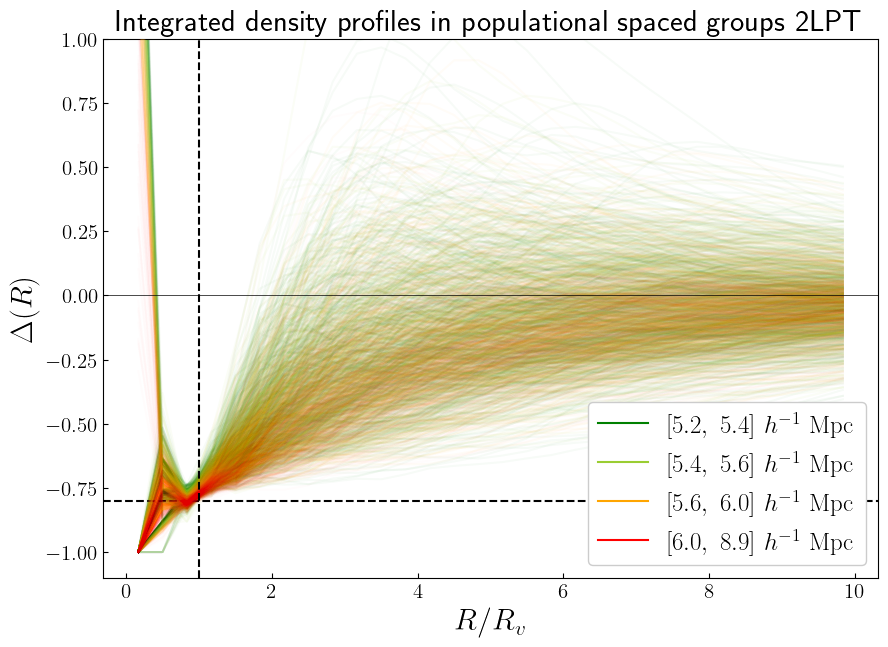

In [8]:
colors = {1: "green", 2: "yellowgreen", 3: "orange", 4: "red"}
limits = [r_min] + [float(i) for i in group_limits]
limits = [round(float(i), 1) for i in limits]

print(limits)
alphas = {1: 0.03, 2: 0.04, 3: 0.03, 4: 0.01}
order = [1, 2, 3, 4]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)
data_delta_profiles = np.load(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/2LPT_results/Numpy_files/{filename}_integrated_delta_profiles_population_spaced_groups.npy", allow_pickle=True)
delta_profiles_groups, radii_groups = data_delta_profiles
plt.ylim(-1.1, 1)

for group in delta_profiles_groups:
    for delta_profile in delta_profiles_groups[group]:
        ax.plot(scaled_bin_centers, delta_profile, marker='None', linestyle='-', color=colors[group], alpha=alphas[group], zorder = order[group-1])


ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.axhline(y=0, color='k', ls='-', zorder=5, lw=0.5)
ax.axvline(x=1, color='k', ls='--', zorder=5)
ax.axhline(y=-0.8, color='k', ls='--')
plt.title('Integrated density profiles in populational spaced groups 2LPT', fontsize=22)
plt.xlabel('$R/R_v$', fontsize=22)
plt.ylabel('$\Delta(R)$', fontsize=22)

dummy_handles = []
for group in sorted(delta_profiles_groups.keys()):
    line, = ax.plot([], [], color=colors[group], label=f'$[{limits[group-1]}, \ {limits[group]}]$'+' $h^{-1} \ \mathrm{Mpc}$')
    dummy_handles.append(line)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, fontsize=18, framealpha = 1)

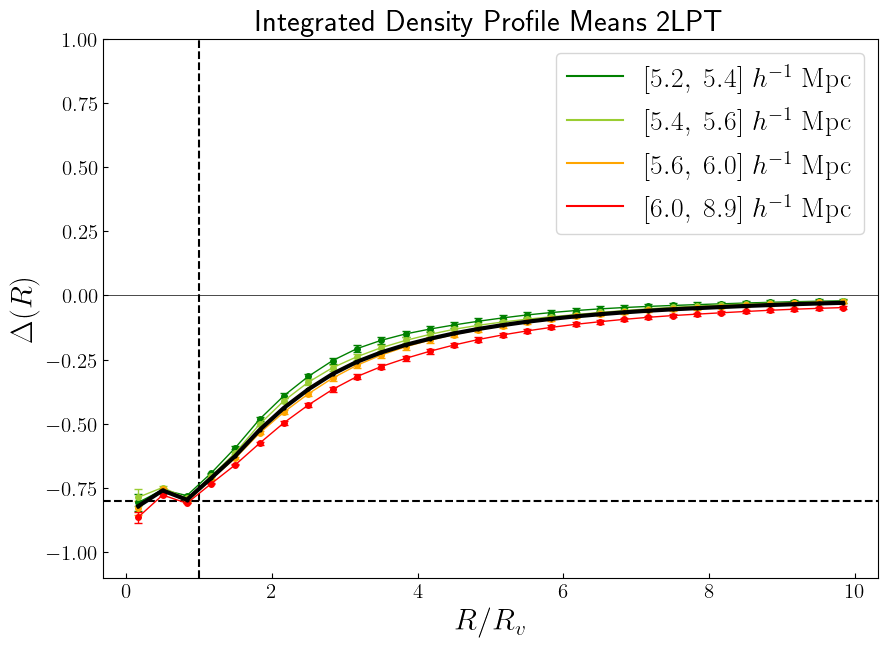

In [9]:
#means
#combine all profiles for mean
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)
plt.ylim(-1.1, 1)

#mean for each bin
for group in delta_profiles_groups:
    group_delta_profiles = np.array(delta_profiles_groups[group])
    mean_profile = np.mean(group_delta_profiles, axis=0)
    std_profile = np.std(group_delta_profiles, axis=0) / np.sqrt(len(group_delta_profiles))

    ax.errorbar(scaled_bin_centers, mean_profile, yerr=std_profile, marker='o', linestyle='-', color=colors[group], label=f'Group {group}', linewidth=1, markersize=4, capsize=3)

#overall mean
all_delta_profiles = []
for group in delta_profiles_groups:
    for delta_profile in delta_profiles_groups[group]:
        all_delta_profiles.append(delta_profile)
all_delta_profiles = np.array(all_delta_profiles)

#create mean
mean_delta_profile = np.mean(all_delta_profiles, axis=0)
std_delta_profile = np.std(all_delta_profiles, axis=0) / np.sqrt(len(all_delta_profiles))

#plot mean
ax.errorbar(scaled_bin_centers, mean_delta_profile, yerr=std_delta_profile, marker='o', linestyle='-', color='black', label= 'Mean', linewidth=3, markersize=2)
ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.axhline(y=0, color='k', ls='-', zorder=1, lw=0.5)
ax.axvline(x=1, color='k', ls='--')
ax.axhline(y=-0.8, color='k', ls='--')
plt.title('Integrated Density Profile Means 2LPT', fontsize=22)
plt.xlabel('$R/R_v$', fontsize=22)
plt.ylabel('$\Delta(R)$', fontsize=22)
ax.legend(handles=handles, fontsize=20)

In [10]:
#differe ntial density profile
def apply_pbc(positions, box_size):
    """
    Wendet periodische Randbedingungen auf Positionen an,
    sodass sie innerhalb der Box bleiben.
    """
    return np.mod(positions, box_size)

def pbc_distance(vec, box_size):
    """
    Berechnet den kürzesten Abstand zwischen zwei Punkten unter
    Berücksichtigung der periodischen Randbedingungen.
    """
    delta = np.abs(vec)
    delta = np.minimum(delta, box_size - delta)  # Kürzesten Abstand berechnen
    return np.linalg.norm(delta)

# Beispielcode für das Berechnen der Dichte innerhalb von Schalen
delta_profiles_groups = {1: [], 2: [], 3: [], 4: []}
density_profile = []

sorted_voids = np.sort(void_data[:, 0])
group_limits = np.percentile(sorted_voids, [25, 50, 75, 100])

scaled_bins = np.linspace(0, 10, 31)  # 30 bins
scaled_bin_centers = (scaled_bins[:-1] + scaled_bins[1:]) / 2

for i, void in enumerate(void_data):
    R_v_i = void[0]
    center = void[1:4]

    # Finde das richtige Bin für jedes Void
    if r_min <= R_v_i < group_limits[0]:  # < 25%
        group = 1
    elif group_limits[0] <= R_v_i < group_limits[1]:  # 25% - 50%
        group = 2
    elif group_limits[1] <= R_v_i < group_limits[2]:  # 50% - 75%
        group = 3
    else:
        group = 4  # Alles darüber in Gruppe 4

    # Finde alle Partikel in der Umgebung der Schale
    indices = tree.query_ball_point(center, 10 * R_v_i)  # Beachte den Radius
    if len(indices) == 0:
        continue

    # Physikalische Schalen (R)
    physical_shells = scaled_bin_centers * R_v_i
    coords_inside = positions[indices]

    # Wende Periodische Randbedingungen auf die Partikel an
    coords_inside = apply_pbc(coords_inside, a)

    # Berechne die Distanzen unter Berücksichtigung der Periodizität
    vecs = coords_inside - center
    dists = np.array([pbc_distance(vec, a) for vec in vecs])

    # Definiere die Schalenkanten
    shell_edges = np.linspace(0, 10 * R_v_i, 31)
    density_profile = []

    # Berechne die Dichte in den Schalen
    for j in range(len(shell_edges) - 1):
        in_shell = (dists >= shell_edges[j]) & (dists < shell_edges[j + 1])
        if np.any(in_shell):
            n_particles = np.sum(in_shell)
            volume = (4/3) * np.pi * (shell_edges[j + 1]**3 - shell_edges[j]**3)
            density = n_particles / volume
            density_profile.append(density)
        else:
            density_profile.append(0)
    
    density_profile = np.array(density_profile)

    # Berechne die Delta-Dichte
    delta_profile = density_profile / n_m - 1
    delta_profiles_groups[group].append(delta_profile)

np.save(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/2LPT_results/Numpy_files/{filename}_differential_delta_profiles_equipopulated_groups.npy", delta_profiles_groups, allow_pickle=True)


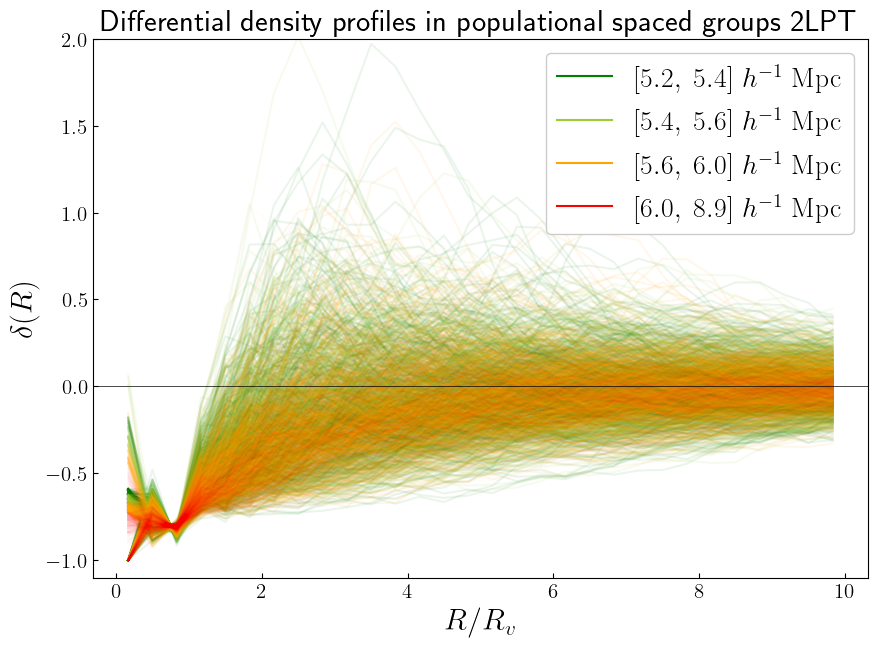

In [11]:
colors = {1: "green", 2: "yellowgreen", 3: "orange", 4: "red"}
alphas = {1: 0.08, 2: 0.08, 3: 0.08, 4: 0.01}
order = [1, 2, 3, 4]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)
delta_profiles_groups = np.load(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/2LPT_results/Numpy_files/{filename}_differential_delta_profiles_equipopulated_groups.npy", allow_pickle=True).item()
plt.ylim(-1.1, 2)

for group in delta_profiles_groups:
    for delta_profile in delta_profiles_groups[group]:
        ax.plot(scaled_bin_centers, delta_profile, marker='None', linestyle='-', color=colors[group], alpha=alphas[group], zorder = order[group-1])

ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.axhline(y=0, color='k', ls='-', zorder=5, lw=0.5)
plt.title('Differential density profiles in populational spaced groups 2LPT', fontsize=22)
plt.xlabel('$R/R_v$', fontsize=22)
plt.ylabel('$\delta(R)$', fontsize=22)

dummy_handles = []
for group in sorted(delta_profiles_groups.keys()):
    line, = ax.plot([], [], color=colors[group], label=f'$[{limits[group-1]}, \ {limits[group]}]$'+' $h^{-1} \ \mathrm{Mpc}$')
    dummy_handles.append(line)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, fontsize=20, framealpha = 1)



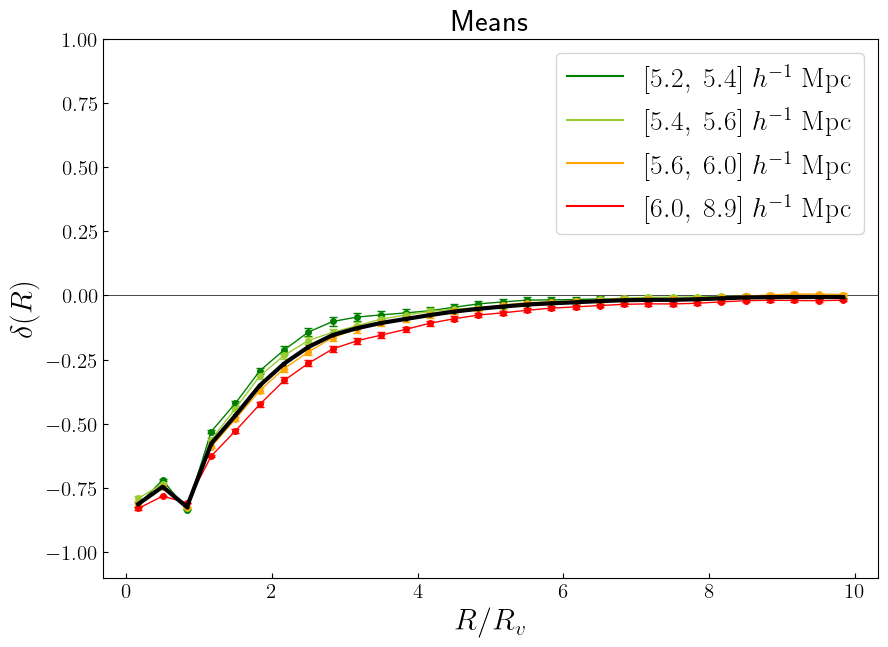

In [12]:
#means
#combine all profiles for mean
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)
plt.ylim(-1.1, 1)

#mean for each bin
for group in delta_profiles_groups:
    group_delta_profiles = np.array(delta_profiles_groups[group])
    mean_profile = np.mean(group_delta_profiles, axis=0)
    std_profile = np.std(group_delta_profiles, axis=0) / np.sqrt(len(group_delta_profiles))

    ax.errorbar(scaled_bin_centers, mean_profile, yerr=std_profile, marker='o', linestyle='-', color=colors[group], label=f'Group {group}', linewidth=1, markersize=4, capsize=3)

#overall mean
all_delta_profiles = []
for group in delta_profiles_groups:
    for delta_profile in delta_profiles_groups[group]:
        all_delta_profiles.append(delta_profile)
all_delta_profiles = np.array(all_delta_profiles)

#create mean
mean_delta_profile = np.mean(all_delta_profiles, axis=0)
std_delta_profile = np.std(all_delta_profiles, axis=0) / np.sqrt(len(all_delta_profiles))

#plot mean
ax.errorbar(scaled_bin_centers, mean_delta_profile, yerr=std_delta_profile, marker='o', linestyle='-', color='black', label= 'Mean', linewidth=3, markersize=2)
ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.axhline(y=0, color='k', ls='-', zorder=1, lw=0.5)
plt.title('Means', fontsize=22)
plt.xlabel('$R/R_v$', fontsize=22)
plt.ylabel('$\delta(R)$', fontsize=22)
ax.legend(handles=handles, fontsize=20)

In [13]:
#velocity profile

velocity_profiles_groups = {1: [], 2: [], 3: [], 4: []}

#sort voids by radius
group_limits = np.percentile(sorted_voids, [25, 50, 75, 100])
print(group_limits)

#define 30 R bins
scaled_bins = np.linspace(0, 10, 31)  # 30 bins
scaled_bin_centers = (scaled_bins[:-1] + scaled_bins[1:]) / 2

velocity_profile = []

for void in void_data:
    R_v_i = void[0]  
    center = void[1:4] 

    # Bestimme die Gruppe basierend auf dem Radius
    group = None
    if r_min <= R_v_i < group_limits[0]:  # < 25%
        group = 1
    elif group_limits[0] <= R_v_i < group_limits[1]:  # 25% - 50%
        group = 2
    elif group_limits[1] <= R_v_i < group_limits[2]:  # 50% - 75%
        group = 3
    else:  
        group = 4 #put everything above in 4

    physical_shells = scaled_bin_centers * R_v_i

    # Finde die Teilchen innerhalb des Voids
    indices = tree.query_ball_point(center, 10 * R_v_i)
    if len(indices) == 0:
        continue

    coords = positions[indices]
    vels = velocities_particles[indices]

    #find radial velocity
    vecs = coords - center
    dists = np.linalg.norm(vecs, axis=1)

    #calculate v_rad= v * r/|r|
    v_rad = np.zeros_like(dists)
    valid = dists > 0
    v_rad[valid] = np.sum(vels[valid] * vecs[valid], axis=1) / dists[valid]

    #mean for each shell
    shell_edges = np.linspace(0, 10 * R_v_i, 31)
    shell_v_rad_mean = []

    for j in range(len(shell_edges) - 1):
        in_shell = (dists >= shell_edges[j]) & (dists < shell_edges[j + 1])
        if np.any(in_shell):
            mean_v = np.mean(v_rad[in_shell])
        else:
            mean_v = np.nan

        shell_v_rad_mean.append(mean_v)

    shell_v_rad_mean = np.array(shell_v_rad_mean)

    # Speichere das Ergebnis in der jeweiligen Gruppe
    velocity_profiles_groups[group].append({'R_void': R_v_i, 'bin_centers': physical_shells, 'shell_v_rad_mean': shell_v_rad_mean})

# Speichern der Daten
np.save(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/2LPT_results/Numpy_files/{filename}_velocity_profiles_groups.npy", velocity_profiles_groups)


[5.39568   5.640455  6.0288675 8.85983  ]


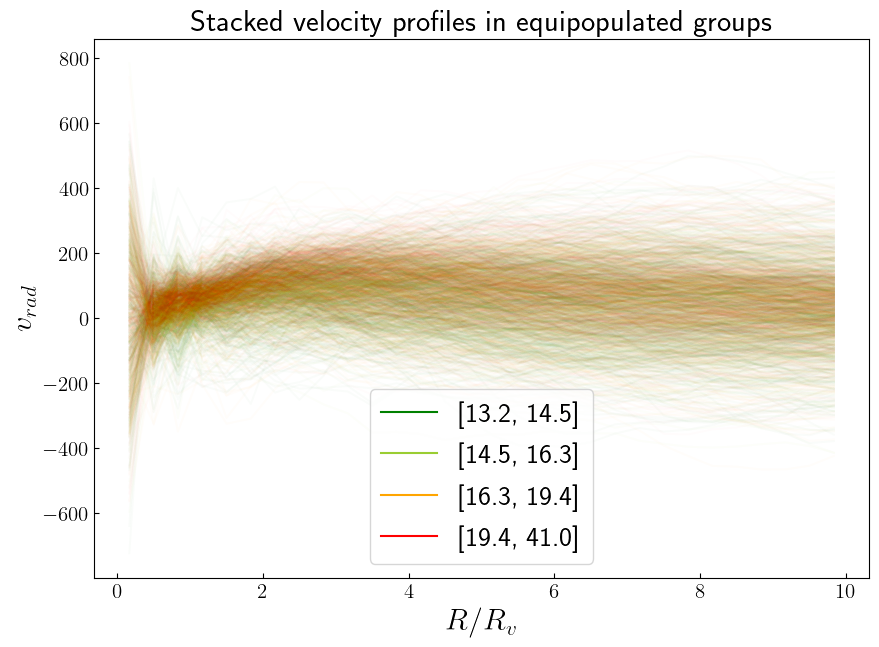

In [14]:
colors = {1: "green", 2: "yellowgreen", 3: "orange", 4: "red"}
alphas = {1: 0.02, 2: 0.02, 3: 0.02, 4: 0.01}
limits = [13.2, 14.5, 16.3, 19.4, 41.0]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)
velocity_profiles_groups = np.load(f"/Users/CHermann/Desktop/MPE/Bachelor_thesis/2LPT_results/Numpy_files/{filename}velocity_profiles_groups.npy", allow_pickle=True).item()

for group in velocity_profiles_groups:
    for velocity_profile in velocity_profiles_groups[group]:
        shell_v_rad_mean = velocity_profile["shell_v_rad_mean"]
        ax.plot(scaled_bin_centers, shell_v_rad_mean, marker='None', linestyle='-', color=colors[group], alpha=alphas[group])


ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)

plt.title('Stacked velocity profiles in equipopulated groups', fontsize=22)
plt.xlabel('$R/R_v$', fontsize=22)
plt.ylabel('$v_{rad}$', fontsize=22)

dummy_handles = []
for group in sorted(velocity_profiles_groups.keys()):
    line, = ax.plot([], [], color=colors[group], label=f'[{limits[group-1]}, {limits[group]}]')
    dummy_handles.append(line)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, fontsize=20)

plt.show()

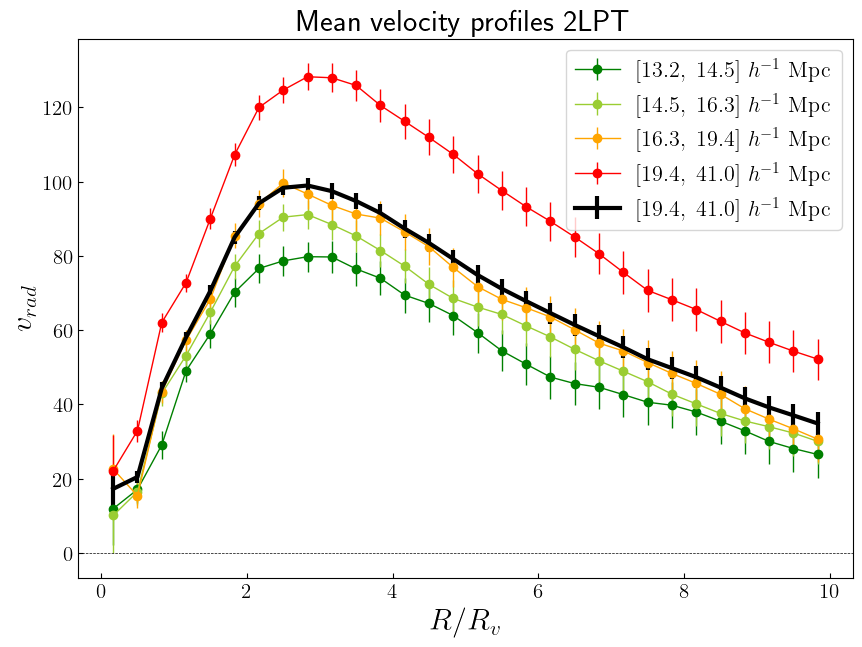

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7), dpi=100)

mean_profiles = {}
for group in velocity_profiles_groups:
    all_profiles = []  
    
    for velocity_profile in velocity_profiles_groups[group]:
        shell_v_rad_mean = velocity_profile["shell_v_rad_mean"]
        all_profiles.append(shell_v_rad_mean)

    if all_profiles:
        all_profiles = np.array(all_profiles)  
        mean_profiles[group] = np.nanmean(all_profiles, axis=0)  # ignore NaNs
        std_profile = np.nanstd(all_profiles, axis=0) / np.sqrt(len(all_profiles))

        #plot mean of each group
        ax.errorbar(scaled_bin_centers, mean_profiles[group], yerr=std_profile, marker='o', color=colors[group], linewidth=1, label=f'$[{limits[group-1]}, \ {limits[group]}]$'+' $h^{-1} \ \mathrm{Mpc}$')

#global mean profile
all_void_profiles = []

for group in velocity_profiles_groups:
    for velocity_profile in velocity_profiles_groups[group]:
        shell_v_rad_mean = velocity_profile["shell_v_rad_mean"]
        all_void_profiles.append(shell_v_rad_mean)


if all_void_profiles:
    all_void_profiles = np.array(all_void_profiles)
    global_mean_profile = np.nanmean(all_void_profiles, axis=0)  # ignore NaNs
    std_profile = np.nanstd(all_void_profiles, axis=0) / np.sqrt(len(all_void_profiles))
    ax.errorbar(scaled_bin_centers, global_mean_profile, yerr=std_profile, color='black', linewidth=3, linestyle='-', label=f'$[{limits[group-1]}, \ {limits[group]}]$'+' $h^{-1} \ \mathrm{Mpc}$')

ax.axhline(y=0, color='k', ls='--', zorder=5, lw=0.5)

ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)
plt.title('Mean velocity profiles 2LPT', fontsize=22)
plt.xlabel('$R/R_v$', fontsize=22)
plt.ylabel('$v_{rad}$', fontsize=22)
ax.legend(fontsize=16)
